# PRISM — Concepts mathématiques et algorithmiques

Ce notebook explique les fondements mathématiques du projet PRISM de manière interactive.
Chaque section introduit un concept avec sa formule, puis propose un widget pour l'explorer visuellement.

**Dépendances :** numpy, matplotlib, ipywidgets (pas besoin de MiniGrid).

**Annexes :**
- `00a_spectral_deep_dive.ipynb` — Eigendecomposition de M
- `00b_calibration_methods.ipynb` — Métriques de calibration (ECE, MI)

---
## Section 0 — Setup

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown
import sys, os

# Ensure prism package is importable
sys.path.insert(0, os.path.abspath('..'))
from prism.pedagogy.toy_grid import ToyGrid

%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

Grille 5×5, 21 états accessibles, 4 murs
Goal : (0, 4)


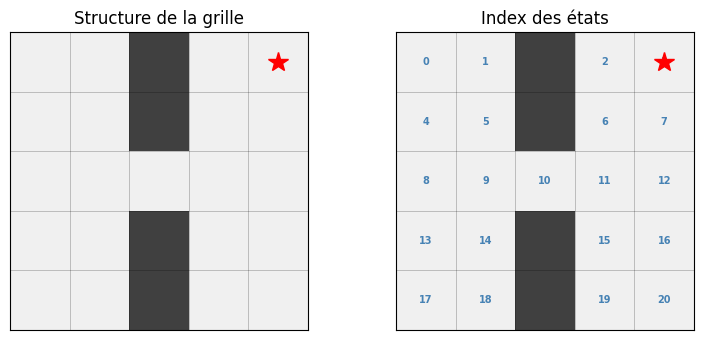

In [60]:
# Grille de référence : deux pièces connectées par un passage
grid = ToyGrid.two_rooms()
print(f"Grille {grid.rows}×{grid.cols}, {grid.n_states} états accessibles, 4 murs")
print(f"Goal : {grid.goal}")

fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
grid.plot(ax=axes[0], title="Structure de la grille")

# Numéroter les états sur fond neutre
grid.plot(ax=axes[1], title="Index des états")
for i, pos in grid.idx_to_pos.items():
    axes[1].text(pos[1], pos[0], str(i), ha='center', va='center',
                 fontsize=7, fontweight='bold', color='steelblue')

plt.tight_layout()
plt.show()

---
## Section 1 — La Successor Representation (SR)

### Intuition

Imaginez un agent qui se promène aléatoirement dans la grille. À chaque pas, il peut aller dans 4 directions (haut, bas, gauche, droite).

La **Successor Representation** ($M$) est un grand tableau qui répond à cette question pour **chaque paire de cases** :

> "Si je pars de la case $s$, **combien de fois** vais-je passer par la case $s'$ dans le futur ?"

Concrètement, $M$ est une **matrice** (un tableau à double entrée) :
- **Ligne** = case de départ $s$
- **Colonne** = case de destination $s'$
- **Valeur** $M(s, s')$ = fréquence de visite attendue de $s'$ en partant de $s$

Notre grille a 21 cases accessibles, donc $M$ est un tableau 21×21 = 441 valeurs. Chaque ligne est une "carte de chaleur" qui dit : "depuis cette case de départ, voici les cases que je visiterai le plus".

Par exemple, la ligne de $M$ pour le coin haut-gauche montrera :
- Les cases **proches** avec des valeurs élevées (visitées souvent)
- Les cases **loin** ou derrière un mur avec des valeurs faibles (rarement atteintes)

### Pourquoi c'est utile

$M$ permet à l'agent d'**évaluer n'importe quel objectif instantanément**.

Exemple : on place de la nourriture en case 15. L'agent veut savoir "est-ce que la case $s$ est un bon point de départ pour atteindre la nourriture ?". Il lui suffit de lire $M(s, 15)$ : si la valeur est élevée, il passera souvent par la case 15, donc c'est un bon départ.

Et si la nourriture **change de place** (disons case 3) ? L'agent n'a pas besoin de tout réapprendre — il lit $M(s, 3)$ à la place. Le tableau $M$ reste le même, seul l'objectif change.

C'est la force de la SR : elle sépare **"où je peux aller"** ($M$, la structure) de **"où je veux aller"** (la récompense). On formalisera cette idée en Section 3 avec $V = M \cdot R$.

### Formule

$$M(s, s') = \mathbb{E}\left[\sum_{t=0}^{\infty} \gamma^t \, \mathbb{1}(s_t = s') \;\middle|\; s_0 = s\right]$$

Décomposons terme par terme :
- $s$ : la case de départ
- $s'$ : une case quelconque dont on veut connaître la fréquence de visite
- $\mathbb{1}(s_t = s')$ : vaut 1 si l'agent est en $s'$ au temps $t$, 0 sinon
- $\gamma^t$ : un poids qui **diminue avec le temps** ($\gamma < 1$), donc les visites lointaines comptent moins
- $\sum_{t=0}^{\infty}$ : on additionne sur tout le futur
- $\mathbb{E}[...]$ : on moyenne sur toutes les trajectoires possibles

Le paramètre $\gamma$ contrôle **jusqu'où l'agent regarde** :
- $\gamma = 0.5$ → l'agent ne considère que ses voisins immédiats (horizon ≈ 2 steps)
- $\gamma = 0.95$ → l'agent anticipe ~20 steps dans le futur
- $\gamma = 0.99$ → l'agent voit très loin (horizon ≈ 100 steps)

### La matrice de transition $T$

Pour calculer $M$, on a besoin de savoir **comment l'agent se déplace**. C'est ce que décrit la matrice de transition $T$ :

$$T_{ij} = P(s' = j \mid s = i)$$

En français : $T_{ij}$ est la **probabilité d'aller de la case $i$ à la case $j$** en un pas.

Dans notre grille, la politique est uniforme (4 directions équiprobables), donc :
- Si $j$ est un voisin accessible de $i$ : $T_{ij} = 0.25$
- Si $j$ est un mur ou n'est pas adjacent : $T_{ij} = 0$
- Si l'agent essaie d'aller dans un mur, il reste sur place : ça augmente $T_{ii}$

$T$ résume toute la **structure de l'environnement** + la **politique de l'agent**.

### Calcul de $M$

On peut décomposer $M$ en additionnant les contributions de chaque pas de temps :

$$M = \underbrace{I}_{t=0} + \underbrace{\gamma \, T}_{t=1} + \underbrace{\gamma^2 T^2}_{t=2} + \underbrace{\gamma^3 T^3}_{t=3} + \ldots$$

Chaque terme a un sens concret :

| Terme | Signification |
|-------|--------------|
| $I$ | À $t=0$, l'agent est à sa case de départ (contribution = 1) |
| $\gamma \, T$ | À $t=1$, il a fait un pas → $T$ donne les probas d'arriver à chaque case |
| $\gamma^2 T^2$ | À $t=2$, il a fait deux pas → $T^2$ donne les probas en 2 étapes |
| $\gamma^t T^t$ | À $t$ quelconque, pondéré par $\gamma^t$ (les pas lointains comptent moins) |

Cette somme infinie converge (car $\gamma < 1$) et vaut :

$$M = (I - \gamma T)^{-1}$$

Le graphe ci-dessous montre **une ligne** de ce tableau : pour un état de départ choisi, la fréquence de visite de chaque case.

In [61]:
def plot_sr_interactive(gamma, state):
    """Affiche M*[s, :] pour un état de départ donné."""
    M_star = grid.true_sr(gamma)
    horizon = 1 / (1 - gamma)

    fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    row = M_star[state]
    row_norm = row / row.max()
    grid.plot(values=row_norm, ax=ax,
              title=f"Occupancy future depuis s={state} (γ={gamma:.2f})",
              cmap='plasma', vmin=0, vmax=1)
    pos = grid.idx_to_pos[state]
    ax.plot(pos[1], pos[0], 'wo', markersize=12, zorder=5,
            markeredgecolor='black', markeredgewidth=1.5)

    plt.tight_layout()
    plt.show()
    print(f"\"Si l'agent part de ⚪, quelles cases va-t-il visiter ?\"")
    print(f"Jaune = souvent, violet = rarement, gris = mur")
    print(f"γ = {gamma:.2f} → horizon ≈ {horizon:.0f} steps")

widgets.interact(
    plot_sr_interactive,
    gamma=widgets.FloatSlider(value=0.95, min=0.5, max=0.99, step=0.01,
                              description='γ', continuous_update=False),
    state=widgets.IntSlider(value=0, min=0, max=grid.n_states-1,
                            description='s (départ)')
);

interactive(children=(FloatSlider(value=0.95, continuous_update=False, description='γ', max=0.99, min=0.5, ste…

### Lecture du graphe

> "Si l'agent part de ⚪, quelles cases va-t-il visiter dans le futur ?"

- **Jaune** = case visitée souvent (proche de ⚪ ou facile d'accès)
- **Violet** = case rarement atteinte (loin, ou de l'autre côté du mur)
- **Gris** = mur (inaccessible)

**À essayer :**
- Déplacez **s** → le pattern jaune suit l'état de départ
- Montez **γ vers 0.99** → l'agent "voit" loin, jaune partout
- Baissez **γ vers 0.5** → l'agent ne voit que ses voisins immédiats

---
## Section 2 — Apprentissage TD(0) de M

### Le problème

En Section 1, on a calculé $M = (I - \gamma T)^{-1}$. Mais ce calcul nécessite de connaître $T$ — toutes les probabilités de transition de l'environnement.

En pratique, **l'agent ne connaît pas $T$**. Il ne sait pas à l'avance où mènent les murs, les passages, etc. Il doit découvrir la structure en **se déplaçant et en observant**.

C'est comme si vous arriviez dans une ville inconnue sans carte : vous ne pouvez pas calculer le meilleur chemin à l'avance. Vous devez explorer, et **construire votre carte mentale au fur et à mesure**.

### Pourquoi l'agent a besoin d'un bon $M$

Rappel Section 1 : $M$ permet d'évaluer n'importe quel objectif (la nourriture en case 15 → lire $M(s, 15)$). Mais ça ne marche que **si $M$ reflète correctement la structure de l'environnement**.

Un $M$ faux donnerait de mauvaises évaluations : l'agent pourrait croire qu'une case est facile à atteindre alors qu'il y a un mur entre les deux.

On note :
- $M^*$ = le résultat de la formule $(I - \gamma T)^{-1}$ (Section 1). C'est la **cible** — le $M$ parfait qu'on obtiendrait si on connaissait $T$.
- $M$ = ce que l'agent a **appris jusqu'ici**. Au début c'est faux, mais avec l'expérience $M$ se rapproche de $M^*$.

Le but de l'apprentissage est que $M \to M^*$ : que la carte mentale de l'agent devienne aussi bonne que s'il avait eu la carte complète depuis le début.

### Comment apprendre : Temporal Difference (TD)

À chaque pas, l'agent est en $s$ et arrive en $s'$. Il peut comparer **ce qu'il prédit** avec **ce qu'il observe** :

- **Prédit** : $M(s, :)$ — sa carte actuelle des fréquences depuis $s$
- **Observé** : $e(s') + \gamma \cdot M(s', :)$ — "je suis en $s'$ maintenant (= $e(s')$), et depuis $s'$ je prédis $M(s', :)$ pour la suite"

La différence est l'**erreur TD** :

$$\delta_M(s) = \underbrace{e(s') + \gamma \cdot M(s', :)}_{\text{observé}} - \underbrace{M(s, :)}_{\text{prédit}}$$

L'agent corrige sa prédiction dans la direction de l'erreur :

$$M(s, :) \leftarrow M(s, :) + \alpha_M \cdot \delta_M(s)$$

### Le taux d'apprentissage $\alpha_M$

$\alpha_M$ contrôle **de combien l'agent corrige sa prédiction** après chaque observation.

**Analogie** : vous pensez qu'il faut 30 minutes pour aller au travail. Aujourd'hui il a fallu 40 minutes. Comment mettez-vous à jour votre estimation ?

| $\alpha_M$ | Correction | Nouvelle estimation | Comportement |
|-----------|-----------|-------------------|-------------|
| 0.01 | 1% de l'erreur | 30 + 0.01 × (40-30) = **30.1 min** | Très prudent, lent à s'adapter |
| 0.1 | 10% de l'erreur | 30 + 0.1 × (40-30) = **31 min** | Équilibré |
| 1.0 | 100% de l'erreur | 30 + 1.0 × (40-30) = **40 min** | Fait confiance aveuglément à la dernière observation |

Un $\alpha_M$ trop grand fait osciller l'agent (il surréagit à chaque observation). Un $\alpha_M$ trop petit le rend très lent à apprendre.

$M$ est initialisé à $I$ (la matrice identité : chaque état prédit uniquement lui-même, aucune connaissance de la structure).

In [62]:
# M* = le vrai M calculé en Section 1 (sert de référence)
M_star_ref = grid.true_sr(0.95)

def td_learning_demo(alpha_M, n_steps, state):
    """Simule n_steps de TD(0) et montre la convergence."""
    gamma = 0.95
    M = np.eye(grid.n_states)  # Init à I
    errors = []

    # Random walk
    traj = grid.random_walk(n_steps, seed=42)

    for t in range(len(traj) - 1):
        s, s_next = traj[t], traj[t + 1]
        delta, M = grid.td_update(M, s, s_next, gamma, alpha_M)
        if t % 10 == 0:
            err = np.linalg.norm(M - M_star_ref, 'fro') / grid.n_states
            errors.append((t, err))

    fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

    # Gauche : courbe de convergence
    steps, errs = zip(*errors)
    axes[0].plot(steps, errs, 'b-', linewidth=1.5)
    axes[0].set_xlabel('Steps (expérience)')
    axes[0].set_ylabel('Erreur M vs M*')
    axes[0].set_title(f'Convergence M → M*')
    axes[0].set_ylim(bottom=0)
    axes[0].grid(True, alpha=0.3)

    # Droite : M appris pour l'état choisi (normalisé, comme Section 1)
    row = M[state]
    row_norm = row / max(row.max(), 1e-8)
    grid.plot(values=row_norm, ax=axes[1],
              title=f"M appris depuis s={state}", cmap='plasma', vmin=0, vmax=1)
    pos = grid.idx_to_pos[state]
    axes[1].plot(pos[1], pos[0], 'wo', markersize=12, zorder=5,
                 markeredgecolor='black', markeredgewidth=1.5)

    plt.tight_layout()
    plt.show()
    print(f"Erreur finale : {errs[-1]:.4f}")
    print()
    print("Gauche : écart entre le M appris et le vrai M (Section 1) — descend avec l'expérience")
    print("Droite : avec assez de steps, cette carte converge vers celle de la Section 1 (= M*)")
    print()
    print("À essayer :")
    print("  α petit (0.01) → apprentissage lent mais stable")
    print("  α grand (0.5)  → apprentissage rapide mais instable (courbe qui oscille)")

widgets.interact(
    td_learning_demo,
    alpha_M=widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01,
                                description='α_M', continuous_update=False),
    n_steps=widgets.IntSlider(value=500, min=50, max=3000, step=50,
                               description='Steps', continuous_update=False),
    state=widgets.IntSlider(value=0, min=0, max=grid.n_states-1,
                            description='s (départ)')
);

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='α_M', max=0.5, min=0.01, st…

---
## Section 3 — Décomposition V = M · R

### La question

L'agent connaît la structure de l'environnement (via $M$). Maintenant il veut **prendre des décisions** : "quelle case est la meilleure pour moi en ce moment ?"

Pour ça, il a besoin de deux informations :
1. **Où est la récompense ?** → c'est le vecteur $R$
2. **Est-ce que je peux y accéder facilement ?** → c'est déjà dans $M$

### Le vecteur de récompense $R$

$R$ est un vecteur simple : une valeur par case.

$$R(s) = \text{récompense obtenue en arrivant en } s$$

Dans notre grille, il y a de la nourriture à une seule case (le "goal") :
- $R(\text{goal}) = 1$
- $R(\text{partout ailleurs}) = 0$

### La valeur $V(s)$

$V(s)$ répond à la question : **"combien de récompense vais-je accumuler en partant de $s$ ?"**

- $V$ élevé = bonne position (proche de la nourriture, accès facile)
- $V$ faible = mauvaise position (loin, ou bloqué par un mur)

### La formule : V = M · R

$$V(s) = \sum_{s'} M(s, s') \cdot R(s')$$

En français : la valeur de $s$ = somme sur toutes les cases de (fréquence de visite × récompense de cette case).

C'est un simple produit matrice-vecteur : $V = M \cdot R$.

### Pourquoi c'est puissant

- **Si le goal bouge** (R change) : il suffit de recalculer $V = M \cdot R$. **M reste le même** — la structure de l'environnement n'a pas changé.
- **Si un mur apparaît** (structure change) : là, $M$ doit être réappris (→ Section 8).

In [63]:
def plot_v_decomposition(goal_row, goal_col, gamma):
    """Montre V = M · R pour différentes positions du goal."""
    goal = (goal_row, goal_col)
    if goal in grid.walls or goal_row >= grid.rows or goal_col >= grid.cols:
        print(f"Position ({goal_row}, {goal_col}) est un mur ou hors grille.")
        return

    M_star = grid.true_sr(gamma)
    R = grid.reward_vector(goal)
    V = M_star @ R

    # Normaliser pour échelles fixes
    row0 = M_star[0]
    row0_norm = row0 / max(row0.max(), 1e-8)
    V_norm = V / max(V.max(), 1e-8)

    fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))

    # Gauche : M[0, :] + goal
    grid.plot(values=row0_norm, ax=axes[0], show_goal=False,
              title='M depuis s=0 (ne change pas)', cmap='plasma', vmin=0, vmax=1)
    axes[0].plot(goal[1], goal[0], 'r*', markersize=18, zorder=5)

    # Droite : V = M · R + goal — même colormap que M
    grid.plot(values=V_norm, ax=axes[1], show_goal=False,
              title='V = M · R', cmap='plasma', vmin=0, vmax=1)
    axes[1].plot(goal[1], goal[0], 'r*', markersize=18, zorder=5)

    plt.tight_layout()
    plt.show()
    print("★ rouge = position de la nourriture (déplacez-la avec les sliders)")
    print("Gauche : M ne bouge pas — la structure de l'environnement ne change pas")
    print("Droite : V change — la valeur des cases dépend de la position du goal")
    print()
    print("→ C'est la force de la SR : un seul M sert pour n'importe quel objectif.")

widgets.interact(
    plot_v_decomposition,
    goal_row=widgets.IntSlider(value=0, min=0, max=grid.rows-1,
                                description='Goal ligne'),
    goal_col=widgets.IntSlider(value=4, min=0, max=grid.cols-1,
                                description='Goal colonne'),
    gamma=widgets.FloatSlider(value=0.95, min=0.5, max=0.99, step=0.01,
                              description='γ', continuous_update=False)
);

interactive(children=(IntSlider(value=0, description='Goal ligne', max=4), IntSlider(value=4, description='Goa…

---
## Section 4 — Erreur de prédiction $\|\delta_M\|$

### Motivation

En Section 2, on a vu que l'agent apprend $M$ en corrigeant ses erreurs ($\delta_M$). On sait que l'erreur globale diminue avec l'expérience.

Mais l'agent a besoin de plus que ça : il a besoin de savoir **où** ses prédictions sont encore mauvaises. "Est-ce que je connais bien cette zone de la grille, ou est-ce que je me trompe encore souvent ici ?"

L'erreur TD $\delta_M(s)$ répond exactement à cette question :
- **Erreur grande** en $s$ → "je me suis trompé en arrivant ici, je connais mal cette zone"
- **Erreur petite** en $s$ → "pas de surprise, ma prédiction était bonne"

C'est le signal de base pour la **métacognition** de l'agent (Sections 5-9) : sa capacité à savoir ce qu'il sait et ce qu'il ne sait pas.

### Du vecteur au nombre

$\delta_M(s)$ est un **vecteur** de 21 valeurs (une par case). Pour obtenir un seul nombre qui résume "l'agent s'est-il trompé en $s$ ?", on prend la **norme** (la "longueur" du vecteur) :

$$\|\delta_M(s)\| = \sqrt{\sum_{s'} \delta_M(s, s')^2}$$

- $\|\delta_M\| = 0$ → prédiction parfaite
- $\|\delta_M\|$ grand → grosse surprise

### Normalisation par le 99e percentile

Les erreurs brutes peuvent valoir 0.003 ou 47 selon $\gamma$ et la taille de la grille. Pour les rendre comparables et les ramener dans $[0, 1]$, on a besoin d'une **référence** : "c'est quoi une grosse erreur ?"

On utilise le **99e percentile** (p99) de toutes les erreurs observées jusqu'ici :

$$\delta_{norm} = \min\left(\frac{\|\delta_M\|}{\text{p99}},\; 1\right)$$

**Pourquoi p99 ?**

Imaginez les erreurs observées triées de la plus petite à la plus grande. Le p99 est la valeur en dessous de laquelle se trouvent 99% des erreurs. En divisant par p99 :
- Une erreur "normale" donne $\delta_{norm}$ entre 0 et 1
- Seul le 1% d'erreurs les plus extrêmes est clippé à 1

**Pourquoi pas le maximum ?** Le max est souvent un pic isolé (par exemple, la toute première erreur de l'agent qui ne sait encore rien). Diviser par ce pic écraserait toutes les autres erreurs vers 0, rendant la carte illisible.

**Pourquoi pas la moyenne ?** La moyenne donnerait des valeurs normalisées > 1 pour toute erreur au-dessus de la moyenne — la moitié des cases seraient clippées à 1.

Le p99 est un bon compromis : il ignore les pics extrêmes tout en conservant le contraste entre les cases.

In [64]:
def plot_td_errors(n_steps, alpha_M):
    """Montre les erreurs TD par état au cours de l'apprentissage."""
    gamma = 0.95
    M = np.eye(grid.n_states)

    # Accumuler les erreurs par état
    error_sum = np.zeros(grid.n_states)
    error_count = np.zeros(grid.n_states)
    all_norms = []

    traj = grid.random_walk(n_steps, seed=42)

    for t in range(len(traj) - 1):
        s, s_next = traj[t], traj[t + 1]
        delta, M = grid.td_update(M, s, s_next, gamma, alpha_M)
        norm = np.linalg.norm(delta)
        error_sum[s] += norm
        error_count[s] += 1
        all_norms.append(norm)

    # Erreur moyenne par état
    mean_error = np.zeros(grid.n_states)
    visited = error_count > 0
    mean_error[visited] = error_sum[visited] / error_count[visited]

    # Normalisation p99
    p99 = np.percentile(all_norms, 99) if all_norms else 1.0
    normalized = np.clip(mean_error / max(p99, 1e-8), 0, 1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

    # Erreur normalisée p99
    grid.plot(values=normalized, ax=axes[0], show_goal=False,
              title='Erreur normalisée par case', cmap='YlOrRd', vmin=0, vmax=1)

    # Nombre de visites
    grid.plot(values=error_count, ax=axes[1], show_goal=False,
              title='Nombre de visites', cmap='Blues')

    plt.tight_layout()
    plt.show()
    print("Gauche : rouge = l'agent se trompe souvent ici (zone mal connue)")
    print("         jaune pâle = peu d'erreurs (zone bien apprise)")
    print("Droite : bleu foncé = case souvent visitée, clair = rarement")
    print()
    print(f"p99 = {p99:.4f}, états non visités : {(~visited).sum()}/{grid.n_states}")
    print()
    print("→ Les cases peu visitées ont souvent plus d'erreurs (l'agent ne les connaît pas)")
    print("→ Augmentez les steps : les erreurs diminuent partout")

widgets.interact(
    plot_td_errors,
    n_steps=widgets.IntSlider(value=500, min=50, max=3000, step=50,
                               description='Steps', continuous_update=False),
    alpha_M=widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01,
                                description='α_M (cf. Sec. 2)', continuous_update=False)
);

interactive(children=(IntSlider(value=500, continuous_update=False, description='Steps', max=3000, min=50, ste…

---
## Section 5 — Carte d'incertitude U(s)

### Le besoin

En Section 4, on a vu que l'erreur $\|\delta_M(s)\|$ mesure "l'agent s'est-il trompé à cet instant, en cette case". Mais cette erreur est **bruitée** : une seule observation peut donner un pic d'erreur juste par malchance.

L'agent a besoin d'une mesure plus **stable** : "est-ce que je connais bien cette zone, **en général** ?" — pas juste "est-ce que je me suis trompé cette fois-ci".

C'est le rôle de $U(s)$ : transformer les erreurs ponctuelles en une **carte de confiance durable**, case par case.

### Intuition

Imaginez que vous visitez un quartier de la ville :
- La **première fois**, vous vous trompez souvent de chemin → incertitude haute
- Après **quelques visites**, vous vous trompez de moins en moins → incertitude diminue
- Après **beaucoup de visites**, vous connaissez bien le quartier → incertitude faible et stable

$U(s)$ reproduit exactement ce comportement. Pour chaque case $s$, l'agent stocke un **historique de ses erreurs récentes** et en fait la moyenne.

### Trois régimes

$U(s)$ dépend du nombre de fois que l'agent a visité la case $s$ :

| Régime | Condition | Ce que fait l'agent | Formule |
|---------|-----------|-------------------|----------|
| **Jamais visité** | $visits(s) = 0$ | "Je ne suis jamais allé ici → incertitude maximale" | $U(s) = U_{prior}$ |
| **Peu de visites** | $0 < visits(s) < K$ | "J'ai quelques observations mais pas assez pour faire une moyenne fiable" | $U(s) = U_{prior} \cdot decay^{visits(s)}$ |
| **Assez de visites** | $visits(s) \geq K$ | "J'ai assez de données → je fais la moyenne de mes $K$ dernières erreurs" | $U(s) = \text{mean}(\text{buffer}(s))$ |

Les paramètres :
- **$U_{prior}$** (défaut 0.8) : incertitude de départ. "Avant de voir quoi que ce soit, je suis incertain à 80%."
- **$decay$** (défaut 0.85) : vitesse de la descente initiale. Chaque visite multiplie l'incertitude par $decay$.
- **$K$** (défaut 20) : taille du buffer. Après $K$ visites, l'agent bascule sur la moyenne de ses erreurs réelles.

### Pourquoi 3 régimes ?

- **Régime 1** (jamais visité) : sans données, on est prudent → $U$ élevé.
- **Régime 2** (cold-start) : on n'a pas encore $K$ erreurs pour faire une moyenne fiable. La formule $U_{prior} \cdot decay^{visits}$ fait baisser $U$ progressivement, comme un a priori qui s'estompe.
- **Régime 3** (convergé) : le buffer est plein → la moyenne reflète les erreurs réelles. Si l'agent connaît bien la zone, les erreurs sont petites → $U$ bas. Si la zone a changé, les erreurs remontent → $U$ remonte aussi.

### Comment choisir la taille du buffer $K$ ?

Le buffer est une **mémoire glissante** : l'agent garde ses $K$ dernières erreurs pour chaque case et en fait la moyenne. Les anciennes erreurs (au-delà de $K$) sont oubliées.

Le choix de $K$ est un compromis entre **stabilité** et **réactivité** :

- **$K$ petit** (ex. 5) : la moyenne ne porte que sur 5 erreurs → elle est **bruitée** (un seul pic la fait monter), mais elle **réagit vite** si la zone change.
- **$K$ grand** (ex. 50) : la moyenne est lissée sur 50 erreurs → elle est **stable**, mais elle met du temps à remonter si l'environnement change (les anciennes erreurs, petites, "diluent" les nouvelles erreurs, grandes).

**En pratique :** on choisit $K$ en fonction de la fréquence à laquelle l'environnement peut changer.
- Environnement **stable** (les murs ne bougent jamais) → $K$ grand (30–50) pour un $U$ bien lissé.
- Environnement **changeant** (obstacles qui apparaissent/disparaissent) → $K$ petit (10–15) pour détecter vite que "cette zone, je ne la connais plus".

Le graphe ci-dessous montre $U(s)$ en fonction du nombre de visites pour une case donnée.

In [65]:
def plot_uncertainty_regimes(U_prior, decay, K):
    """Visualise les 3 régimes de U(s) en fonction du nombre de visites."""
    visits = np.arange(0, 60)

    # Simuler des erreurs de buffer décroissantes (convergence réaliste)
    U_values = []
    buffer = []
    for v in visits:
        if v == 0:
            U_values.append(U_prior)
        elif v < K:
            U_values.append(U_prior * (decay ** v))
        else:
            # Simuler buffer : erreurs décroissantes + bruit
            simulated_error = max(0.01, 0.5 * np.exp(-0.05 * v) + 0.02 * np.sin(v))
            buffer.append(simulated_error)
            if len(buffer) > K:
                buffer = buffer[-K:]
            U_values.append(np.mean(buffer))

    U_values = np.array(U_values)

    fig, ax = plt.subplots(1, 1, figsize=(9, 4))

    # Zones colorées pour les régimes
    ax.axvspan(0, 0.5, alpha=0.15, color='red', label='Non visité')
    ax.axvspan(0.5, K, alpha=0.15, color='orange', label=f'Cold-start (< K={K})')
    ax.axvspan(K, 60, alpha=0.15, color='green', label=f'Convergé (≥ K={K})')

    ax.plot(visits, U_values, 'b-', linewidth=2, label='U(s)')
    ax.axhline(y=U_prior, color='red', linestyle='--', alpha=0.5, label=f'U_prior={U_prior}')
    ax.axvline(x=K, color='gray', linestyle=':', alpha=0.7)

    ax.set_xlabel('Nombre de visites')
    ax.set_ylabel('U(s)')
    ax.set_title('Incertitude U(s) : 3 régimes')
    ax.set_ylim(-0.05, 1.05)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("Lecture du graphe :")
    print(f"  Axe horizontal = nombre de fois que l'agent a visité cette case")
    print(f"  Axe vertical   = incertitude U(s) (1 = ne sait rien, 0 = connaît parfaitement)")
    print(f"  Courbe bleue   = évolution de U au fil des visites")
    print()
    print("Les 3 zones colorées :")
    print(f"  Rouge  (0 visite)  : U = {U_prior} — l'agent n'est jamais venu ici, incertitude maximale")
    print(f"  Orange (1 à {K-1} visites) : U descend vite — chaque visite réduit l'incertitude")
    print(f"    Exemple à 5 visites : U = {U_prior} × {decay}⁵ = {U_prior * decay**5:.3f}")
    print(f"  Vert   (≥ {K} visites)  : U = moyenne des {K} dernières erreurs réelles")
    print(f"    → U se stabilise à un niveau bas si l'agent connaît bien la zone")
    print()
    print("À essayer :")
    print("  U_prior haut (0.95) → l'agent démarre très incertain, la descente est plus longue")
    print("  decay bas (0.7)     → chaque visite réduit beaucoup l'incertitude (descente rapide)")
    print("  K grand (50)        → il faut plus de visites avant de basculer sur les erreurs réelles")

widgets.interact(
    plot_uncertainty_regimes,
    U_prior=widgets.FloatSlider(value=0.8, min=0.5, max=0.95, step=0.05,
                                 description='U_prior', continuous_update=False),
    decay=widgets.FloatSlider(value=0.85, min=0.7, max=0.95, step=0.05,
                               description='decay', continuous_update=False),
    K=widgets.IntSlider(value=20, min=5, max=50, step=5,
                         description='K (buffer)')
);

interactive(children=(FloatSlider(value=0.8, continuous_update=False, description='U_prior', max=0.95, min=0.5…

---
## Section 6 — Signal de confiance C(s)

### Pourquoi ne pas utiliser U directement ?

En Section 5, on a construit $U(s) \in [0, 1]$ : une carte d'incertitude par case. On pourrait s'en servir directement pour prendre des décisions ("si $U > 0.5$, explorer"). Mais $U$ pose deux problèmes :

1. **Pas de seuil net.** $U = 0.35$, c'est incertain ou pas ? La frontière entre "je sais" et "je ne sais pas" est floue. Or l'agent a besoin de **trancher** : "est-ce que je fais confiance à ma prédiction ici, oui ou non ?"

2. **Sensibilité aux paramètres.** $U$ dépend de $U_{prior}$, $decay$, $K$... Ses valeurs brutes varient beaucoup selon la configuration. On veut un signal de confiance dont l'échelle est toujours la même : 0 = aucune confiance, 1 = confiance totale.

### L'idée

On transforme $U$ en un signal de **confiance** $C(s)$ qui a deux propriétés :
- **Inversé** : incertitude haute → confiance basse (et inversement)
- **Décision nette** : la transition entre "confiant" et "pas confiant" est rapide, pas graduelle

Pour ça, on utilise une **sigmoïde** — une fonction en forme de S qui écrase les valeurs vers 0 ou 1 :

$$C(s) = \frac{1}{1 + \exp\left(\beta \cdot (U(s) - \theta_C)\right)}$$

### Les paramètres

| Paramètre | Ce qu'il contrôle | Défaut |
|-----------|------------------|--------|
| $\theta_C$ | Le **centre** : à quelle incertitude la confiance vaut exactement 0.5. "En dessous de $\theta_C$, je suis plutôt confiant. Au-dessus, plutôt pas." | 0.3 |
| $\beta$ | La **pente** : à quel point la transition est brutale. $\beta$ grand = passage quasi instantané entre 0 et 1. $\beta$ petit = transition douce et graduelle. | 10 |

**Exemples concrets** (avec $\beta = 10$, $\theta_C = 0.3$) :
- $U = 0.1$ (peu d'erreurs) → $C \approx 0.88$ — l'agent est **confiant**
- $U = 0.3$ (erreurs moyennes) → $C = 0.50$ — l'agent **hésite**
- $U = 0.6$ (beaucoup d'erreurs) → $C \approx 0.05$ — l'agent **ne fait pas confiance** à sa prédiction

In [66]:
def plot_confidence_sigmoid(beta, theta_C):
    """Visualise la sigmoïde C(U) et la heatmap C sur la grille."""
    U_range = np.linspace(0, 1, 200)
    C_range = 1 / (1 + np.exp(beta * (U_range - theta_C)))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Courbe sigmoïde
    axes[0].plot(U_range, C_range, 'b-', linewidth=2)
    axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    axes[0].axvline(x=theta_C, color='red', linestyle='--', alpha=0.5,
                    label=f'θ_C = {theta_C}')
    axes[0].fill_between(U_range, C_range, alpha=0.1)
    axes[0].set_xlabel('U(s) — Incertitude')
    axes[0].set_ylabel('C(s) — Confiance')
    axes[0].set_title(f'Sigmoïde : β={beta}, θ_C={theta_C}')
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Simuler U après apprentissage partiel (1000 steps)
    # Assez pour que les zones fréquentées soient bien apprises (vert)
    # mais pas assez pour que tout soit appris (contraste vert/rouge)
    gamma = 0.95
    M_star = grid.true_sr(gamma)
    M_partial = np.eye(grid.n_states)
    n_sim = 1000
    traj = grid.random_walk(n_sim, seed=42)

    # Accumuler erreurs par état (comme Section 4)
    error_sum = np.zeros(grid.n_states)
    error_count = np.zeros(grid.n_states)
    all_norms = []
    for t in range(len(traj) - 1):
        s, s_next = traj[t], traj[t+1]
        delta, M_partial = grid.td_update(M_partial, s, s_next, gamma, 0.1)
        norm = np.linalg.norm(delta)
        error_sum[s] += norm
        error_count[s] += 1
        all_norms.append(norm)

    # U = erreur moyenne normalisée par état
    p99 = np.percentile(all_norms, 99) if all_norms else 1.0
    mean_err = np.zeros(grid.n_states)
    visited = error_count > 0
    mean_err[visited] = error_sum[visited] / error_count[visited]
    U_sim = np.where(visited, np.clip(mean_err / max(p99, 1e-8), 0, 1), 0.8)

    C_sim = 1 / (1 + np.exp(beta * (U_sim - theta_C)))

    grid.plot(values=C_sim, ax=axes[1], show_goal=False,
              title='C(s) sur la grille (après 1000 steps)', cmap='RdYlGn', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

    n_green = (C_sim > 0.5).sum()
    n_red = (C_sim <= 0.5).sum()
    C_at_0 = 1/(1+np.exp(beta*(0-theta_C)))
    C_at_1 = 1/(1+np.exp(beta*(1-theta_C)))

    print("Lecture des graphes :")
    print()
    print("Gauche — la sigmoïde C(U) :")
    print(f"  Axe horizontal = incertitude U (0 = sûr, 1 = ne sait rien)")
    print(f"  Axe vertical   = confiance C (0 = pas confiant, 1 = confiant)")
    print(f"  Ligne rouge pointillée = θ_C = {theta_C} → à ce U, la confiance vaut exactement 0.5")
    print(f"  À gauche de θ_C : C monte vers {C_at_0:.2f} (confiant)")
    print(f"  À droite de θ_C : C descend vers {C_at_1:.3f} (pas confiant)")
    print()
    print("Droite — la confiance sur la grille :")
    print(f"  Vert  = confiance élevée (zone bien apprise) — {n_green} cases")
    print(f"  Rouge = confiance faible (zone mal connue) — {n_red} cases")
    print(f"  Gris  = mur")
    print()
    print("À essayer :")
    print("  β petit (2)  → transition douce, beaucoup de cases en jaune (intermédiaire)")
    print("  β grand (25) → transition brutale, les cases sont soit vertes soit rouges")
    print("  θ_C bas (0.1) → l'agent exige très peu d'erreurs pour être confiant → plus de rouge")
    print("  θ_C haut (0.6) → l'agent est indulgent → plus de vert")

widgets.interact(
    plot_confidence_sigmoid,
    beta=widgets.FloatSlider(value=10, min=2, max=25, step=1,
                              description='β (pente)', continuous_update=False),
    theta_C=widgets.FloatSlider(value=0.3, min=0.1, max=0.6, step=0.05,
                                 description='θ_C (centre)', continuous_update=False)
);

interactive(children=(FloatSlider(value=10.0, continuous_update=False, description='β (pente)', max=25.0, min=…

---
## Section 7 — Exploration adaptative

### Le problème

En Section 3, on a vu que l'agent choisit ses actions en fonction de $V(s) = M \cdot R$ : il va vers les cases de haute valeur (proches du goal). C'est l'**exploitation** — faire ce qu'on sait être bon.

Mais il y a un piège : si l'agent ne fait qu'exploiter, il reste dans les zones qu'il connaît déjà et **ne découvre jamais le reste de la grille**. Il pourrait passer à côté d'un meilleur chemin, ou ne jamais apprendre ce qu'il y a de l'autre côté du mur.

L'agent doit donc aussi **explorer** — aller dans des zones inconnues pour améliorer son $M$. C'est le dilemme classique exploration vs exploitation.

### La solution naïve : epsilon-greedy

L'approche standard est de choisir une action aléatoire avec probabilité $\varepsilon$, et la meilleure action sinon. Mais avec un $\varepsilon$ fixe (ex. 0.1), l'agent explore **autant** dans les zones qu'il connaît bien que dans les zones inconnues. C'est du gaspillage.

### Explorer là où c'est utile

L'idée d'explorer davantage dans les zones incertaines est un principe classique en RL (UCB, curiosité intrinsèque, etc.). Ce que PRISM apporte, c'est d'utiliser la carte $U(s)$ construite à partir des erreurs TD de la SR (Section 5) comme signal d'incertitude. L'agent sait **où** il est incertain, et il s'en sert de deux façons complémentaires :

### 1. Epsilon adaptatif

$$\varepsilon(s) = \varepsilon_{min} + (\varepsilon_{max} - \varepsilon_{min}) \cdot U(s)$$

Au lieu d'un $\varepsilon$ fixe, chaque case a son propre taux d'exploration :
- **Zone bien connue** ($U$ bas) → $\varepsilon \approx \varepsilon_{min}$ → l'agent exploite (il sait quoi faire)
- **Zone inconnue** ($U$ haut) → $\varepsilon \approx \varepsilon_{max}$ → l'agent explore (il a besoin d'apprendre)

### 2. Bonus d'exploration

$$V_{explore}(s) = V(s) + \lambda \cdot U(s)$$

L'incertitude agit comme une **récompense bonus** : les zones inconnues deviennent artificiellement attractives. L'agent est "curieux" — il est attiré par ce qu'il ne connaît pas encore.

- $\lambda = 0$ → pas de bonus, l'agent ne fait qu'exploiter
- $\lambda$ grand → l'agent privilégie l'exploration, même si le goal est ailleurs

In [67]:
def plot_exploration(eps_min, eps_max, lam):
    """Visualise epsilon adaptatif et V_explore."""
    gamma = 0.95
    M_star = grid.true_sr(gamma)
    R = grid.reward_vector()
    V = M_star @ R

    # Simuler U après apprentissage partiel (1000 steps, comme Section 6)
    M_partial = np.eye(grid.n_states)
    traj = grid.random_walk(1000, seed=42)
    error_sum = np.zeros(grid.n_states)
    error_count = np.zeros(grid.n_states)
    all_norms = []
    for t in range(len(traj) - 1):
        s, s_next = traj[t], traj[t+1]
        delta, M_partial = grid.td_update(M_partial, s, s_next, gamma, 0.1)
        norm = np.linalg.norm(delta)
        error_sum[s] += norm
        error_count[s] += 1
        all_norms.append(norm)
    p99 = np.percentile(all_norms, 99) if all_norms else 1.0
    mean_err = np.zeros(grid.n_states)
    visited = error_count > 0
    mean_err[visited] = error_sum[visited] / error_count[visited]
    U = np.where(visited, np.clip(mean_err / max(p99, 1e-8), 0, 1), 0.8)

    # Epsilon adaptatif
    eps = eps_min + (eps_max - eps_min) * U

    # V_explore
    V_norm = V / max(V.max(), 1e-8)
    V_explore = V_norm + lam * U
    V_explore_norm = V_explore / max(V_explore.max(), 1e-8)

    fig, axes = plt.subplots(1, 3, figsize=(13, 3.5))

    grid.plot(values=eps, ax=axes[0], show_goal=False,
              title=f'ε(s) — taux d\'exploration',
              cmap='YlOrRd', vmin=eps_min, vmax=eps_max)

    grid.plot(values=V_norm, ax=axes[1], show_goal=False,
              title='V(s) — sans bonus', cmap='plasma', vmin=0, vmax=1)

    grid.plot(values=V_explore_norm, ax=axes[2], show_goal=False,
              title=f'V + λ·U — avec bonus (λ={lam})', cmap='plasma', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

    best_V = grid.idx_to_pos[np.argmax(V)]
    best_Vx = grid.idx_to_pos[np.argmax(V_explore)]

    print("Lecture des graphes :")
    print()
    print("Gauche — ε(s), le taux d'exploration par case :")
    print(f"  Rouge = exploration forte (zone inconnue, U élevé → ε ≈ {eps_max})")
    print(f"  Jaune pâle = exploration faible (zone connue, U bas → ε ≈ {eps_min})")
    print(f"  → L'agent fait des actions aléatoires plus souvent dans les zones rouges")
    print()
    print("Centre — V(s), la valeur sans bonus :")
    print(f"  Jaune = case de haute valeur (proche du goal)")
    print(f"  Violet = case de faible valeur (loin du goal)")
    print(f"  → L'agent est attiré uniquement vers le goal")
    print()
    print("Droite — V + λ·U, la valeur avec bonus d'exploration :")
    print(f"  Les zones inconnues (U élevé) reçoivent un bonus → elles deviennent plus jaunes")
    print(f"  → L'agent est attiré à la fois vers le goal ET vers les zones inconnues")
    print()
    print(f"Case la plus attractive : sans bonus = {best_V}, avec bonus (λ={lam}) = {best_Vx}")
    print()
    print("À essayer :")
    print("  λ = 0   → droite identique au centre (pas de curiosité)")
    print("  λ grand (2.0) → les zones inconnues dominent, l'agent ignore presque le goal")
    print("  ε_max haut (0.9) → exploration très agressive dans les zones rouges")

widgets.interact(
    plot_exploration,
    eps_min=widgets.FloatSlider(value=0.01, min=0.001, max=0.1, step=0.01,
                                 description='ε_min', continuous_update=False),
    eps_max=widgets.FloatSlider(value=0.5, min=0.2, max=0.9, step=0.1,
                                 description='ε_max', continuous_update=False),
    lam=widgets.FloatSlider(value=0.5, min=0.0, max=2.0, step=0.1,
                             description='λ (bonus)', continuous_update=False)
);

interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='ε_min', max=0.1, min=0.001…

---
## Section 8 — Détection de changement

### Le problème

Jusqu'ici, on a supposé que l'environnement ne change pas : les murs restent en place, les passages restent ouverts. Mais que se passe-t-il si un **mur apparaît** et bloque le passage entre les deux pièces ?

Le $M$ que l'agent a appris reflète l'**ancienne** structure. Il prédit par exemple "depuis la pièce gauche, je passerai souvent par le passage pour atteindre la pièce droite". Mais le passage est bloqué — cette prédiction est maintenant **fausse**.

L'agent a besoin de **détecter** que quelque chose a changé, pour savoir qu'il doit réapprendre son $M$.

### Comment le détecter ?

Le mécanisme est déjà en place grâce aux sections précédentes :

1. **L'environnement change** → le $M$ appris ne correspond plus à la réalité
2. **Les erreurs TD augmentent** (Section 4) → l'agent se trompe quand il passe par la zone modifiée
3. **$U(s)$ remonte** (Section 5) → le buffer d'erreurs se remplit de nouvelles erreurs élevées
4. **$C(s)$ chute** (Section 6) → la confiance baisse dans la zone affectée

Il ne reste qu'à résumer cette information en un seul signal : "est-ce que l'environnement vient de changer ?"

### Le score de changement

On regarde l'incertitude moyenne des cases **récemment visitées** :

$$\text{score} = \frac{1}{|S_{recent}|} \sum_{s \in S_{recent}} U(s)$$

- $S_{recent}$ = les cases visitées dans les ~50 derniers pas
- En temps normal, ces cases sont bien connues → $U$ bas → score bas
- Après un changement, les erreurs remontent → $U$ monte → **le score fait un pic**

On compare ce score à un seuil :

$$\text{change\_detected} = \mathbb{1}(\text{score} > \theta_{change})$$

### Pourquoi les états "récents" ?

On ne regarde pas toute la grille, seulement les cases **récemment visitées**, parce que :
- Le changement n'affecte que la zone modifiée — les cases loin du changement gardent un $U$ bas
- L'agent ne peut constater le changement que là où il passe — s'il n'est pas allé dans la zone modifiée, il ne peut pas encore le savoir
- En moyennant sur les cases récentes, le signal est **localisé** : il reflète ce que l'agent vit en ce moment

Le graphe ci-dessous simule un scénario : l'agent apprend pendant 300 steps, puis le passage est bloqué. On observe le score de changement au fil du temps.

In [68]:
def plot_change_detection(theta_change):
    """Simule apprentissage, perturbation, et détection de changement."""
    gamma, alpha = 0.95, 0.1
    K = 10  # buffer size pour U

    grid_normal = ToyGrid.two_rooms()
    M = np.eye(grid_normal.n_states)
    n_states = grid_normal.n_states

    from collections import deque
    buffers = [deque(maxlen=K) for _ in range(n_states)]
    visit_counts = np.zeros(n_states)
    recent_states = deque(maxlen=50)
    all_deltas = []

    scores = []

    total_steps = 600
    change_at = 300

    traj = grid_normal.random_walk(total_steps, seed=42)

    for t in range(total_steps):
        s = traj[t]
        s_next = traj[t + 1] if t + 1 < len(traj) else s

        delta, M = grid_normal.td_update(M, s, s_next, gamma, alpha)
        norm = np.linalg.norm(delta)

        # Après step 300 : on simule le blocage du passage.
        # En vrai, les transitions changeraient. Ici on simule l'effet :
        # les erreurs TD deviennent plus grandes car M reflète l'ancienne structure.
        if t >= change_at:
            norm *= 3.0

        all_deltas.append(norm)
        p99 = np.percentile(all_deltas[-500:], 99) if len(all_deltas) > 10 else 1.0
        normalized = min(norm / max(p99, 1e-8), 1.0)

        visit_counts[s] += 1
        buffers[s].append(normalized)
        recent_states.append(s)

        # Calculer le score toutes les 5 steps
        if t % 5 == 0 and len(recent_states) > 5:
            unique_recent = set(recent_states)
            U_values = []
            for rs in unique_recent:
                if visit_counts[rs] == 0:
                    U_values.append(0.8)
                elif visit_counts[rs] < K:
                    U_values.append(0.8 * (0.85 ** visit_counts[rs]))
                else:
                    U_values.append(np.mean(buffers[rs]))
            score = np.mean(U_values)
            scores.append((t, score))

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    steps, change_scores = zip(*scores)
    ax.plot(steps, change_scores, 'b-', linewidth=1.5, label='Score de changement')
    ax.axhline(y=theta_change, color='red', linestyle='--', linewidth=2,
               label=f'Seuil θ = {theta_change}')
    ax.axvline(x=change_at, color='orange', linestyle='-', linewidth=2,
               alpha=0.7, label='Passage bloqué (step 300)')

    # Colorier la zone de détection (score > seuil)
    for i in range(len(steps)-1):
        if change_scores[i] > theta_change:
            ax.axvspan(steps[i], steps[i+1], alpha=0.15, color='red')

    ax.set_xlabel('Steps (temps)')
    ax.set_ylabel('Score de changement')
    ax.set_title('Scénario : l\'agent apprend, puis le passage est bloqué')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)

    # Annotations sur le graphe
    ax.annotate('Apprentissage normal\n(erreurs diminuent)',
                xy=(150, 0.15), fontsize=9, ha='center', color='steelblue')
    ax.annotate('Passage bloqué !\n(erreurs remontent)',
                xy=(450, 0.85), fontsize=9, ha='center', color='red')

    plt.tight_layout()
    plt.show()

    # Latence de détection
    post_change = [(s, sc) for s, sc in scores if s >= change_at and sc > theta_change]

    print("Lecture du graphe :")
    print()
    print("C'est un film : le temps avance de gauche à droite (0 → 600 steps).")
    print()
    print("  Axe horizontal = le temps (nombre de steps d'expérience)")
    print("  Axe vertical   = le score de changement (= moyenne de U sur les cases récentes)")
    print("  Courbe bleue   = le score au fil du temps")
    print(f"  Ligne rouge horizontale = seuil θ_change = {theta_change}")
    print("  Ligne orange verticale  = step 300, le moment où le passage est bloqué")
    print("  Zone rouge transparente = le score dépasse le seuil → changement détecté")
    print()
    print("Le scénario en 2 phases :")
    print("  Steps 0–300   : l'agent explore la grille normalement.")
    print("                  Il apprend M, ses erreurs diminuent, le score baisse.")
    print("  Step 300       : le passage entre les deux pièces est bloqué par un mur.")
    print("                  Le M appris est maintenant faux → les erreurs remontent → le score monte.")
    print()
    if post_change:
        latency = post_change[0][0] - change_at
        print(f"  → Détection après {latency} steps (le score franchit le seuil rouge)")
    else:
        print(f"  → Pas de détection : le score ne franchit jamais le seuil (trop haut ?)")
    print()
    print("À essayer :")
    print("  θ bas (0.2)  → détection très rapide, mais risque de fausses alarmes avant step 300")
    print("  θ haut (0.7) → détection lente ou absente, mais pas de fausses alarmes")

widgets.interact(
    plot_change_detection,
    theta_change=widgets.FloatSlider(value=0.5, min=0.1, max=0.8, step=0.05,
                                      description='θ_change', continuous_update=False)
);

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='θ_change', max=0.8, min=0.1…

---
## Section 9 — Signal "je ne sais pas" (IDK)

### Le besoin

En Section 6, on a construit $C(s)$ : une confiance entre 0 et 1 pour chaque case. Mais l'agent doit prendre une **décision binaire** : "est-ce que je fais confiance à ma prédiction ici, ou pas ?"

C'est comme un médecin qui regarde une radio : il peut être plus ou moins sûr de son diagnostic, mais à un moment il doit trancher — "je sais ce que c'est" ou "je ne sais pas, je demande un second avis".

### La règle

$$\text{IDK}(s) = \mathbb{1}\left(C(s) < \theta_{idk}\right)$$

- Si $C(s) \geq \theta_{idk}$ → l'agent est assez confiant → il **exploite** (fait ce que $V$ lui dit)
- Si $C(s) < \theta_{idk}$ → l'agent n'est pas assez confiant → il signale **"je ne sais pas"** et explore à la place

$\theta_{idk}$ (défaut 0.3) est le **seuil de confiance minimale**. C'est un choix de design :
- **$\theta_{idk}$ bas** (0.1) → l'agent dit rarement "je ne sais pas" — il fait confiance même avec peu de certitude
- **$\theta_{idk}$ haut** (0.6) → l'agent est très prudent — il dit "je ne sais pas" dès que la confiance n'est pas élevée

In [69]:
def plot_idk_signal(theta_idk, beta, theta_C):
    """Visualise les zones où l'agent dit 'je ne sais pas'."""
    gamma = 0.95
    M_star = grid.true_sr(gamma)

    # Simuler U après apprentissage partiel (1000 steps, comme Sections 6-7)
    M_partial = np.eye(grid.n_states)
    traj = grid.random_walk(1000, seed=42)
    error_sum = np.zeros(grid.n_states)
    error_count = np.zeros(grid.n_states)
    all_norms = []
    for t in range(len(traj) - 1):
        s, s_next = traj[t], traj[t+1]
        delta, M_partial = grid.td_update(M_partial, s, s_next, gamma, 0.1)
        norm = np.linalg.norm(delta)
        error_sum[s] += norm
        error_count[s] += 1
        all_norms.append(norm)
    p99 = np.percentile(all_norms, 99) if all_norms else 1.0
    mean_err = np.zeros(grid.n_states)
    visited = error_count > 0
    mean_err[visited] = error_sum[visited] / error_count[visited]
    U = np.where(visited, np.clip(mean_err / max(p99, 1e-8), 0, 1), 0.8)

    # Confiance
    C = 1 / (1 + np.exp(beta * (U - theta_C)))

    # IDK signal
    idk = (C < theta_idk).astype(float)
    pct_idk = 100 * idk.mean()
    n_idk = int(idk.sum())

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Gauche : C(s) sur la grille
    grid.plot(values=C, ax=axes[0], show_goal=False,
              title='C(s) — Confiance', cmap='RdYlGn', vmin=0, vmax=1)

    # Droite : IDK binaire (vert = confiant, rouge = IDK)
    from matplotlib.colors import ListedColormap
    cmap_idk = ListedColormap(['#2ecc71', '#e74c3c'])
    idk_grid = grid.to_grid(idk)
    axes[1].imshow(idk_grid, cmap=cmap_idk, vmin=0, vmax=1,
                   origin='upper', interpolation='nearest')
    axes[1].set_title(f'IDK (θ = {theta_idk}) — {n_idk}/{grid.n_states} cases en IDK')
    for w in grid.walls:
        axes[1].add_patch(plt.Rectangle((w[1]-0.5, w[0]-0.5), 1, 1,
                          fill=True, color='gray', alpha=0.8))
    axes[1].set_xticks(np.arange(-0.5, grid.cols, 1), minor=True)
    axes[1].set_yticks(np.arange(-0.5, grid.rows, 1), minor=True)
    axes[1].grid(which='minor', color='black', linewidth=0.5, alpha=0.3)
    axes[1].tick_params(which='both', bottom=False, left=False,
                        labelbottom=False, labelleft=False)

    plt.tight_layout()
    plt.show()

    print("Lecture des graphes :")
    print()
    print("Gauche — C(s), la confiance par case (même carte que Section 6) :")
    print("  Vert  = confiance élevée (zone bien apprise)")
    print("  Rouge = confiance faible (zone mal connue)")
    print()
    print("Droite — la décision binaire IDK :")
    print(f"  Vert  = C ≥ {theta_idk} → l'agent fait confiance → il exploite")
    print(f"  Rouge = C < {theta_idk} → l'agent dit \"je ne sais pas\" → il explore")
    print(f"  Gris  = mur")
    print()
    print(f"  → {n_idk} cases en IDK sur {grid.n_states} ({pct_idk:.0f}%)")
    print()
    print("Le lien entre les deux graphes :")
    print(f"  Le seuil θ_idk = {theta_idk} coupe la carte de confiance en deux.")
    print("  Toutes les cases rouges/oranges à gauche (C faible) deviennent rouges à droite (IDK).")
    print("  Toutes les cases vertes à gauche (C élevée) restent vertes à droite.")
    print()
    print("À essayer :")
    print("  θ_idk bas (0.1)  → presque tout est vert (l'agent fait confiance facilement)")
    print("  θ_idk haut (0.6) → beaucoup de rouge (l'agent est très prudent)")
    print("  β et θ_C changent la carte de confiance à gauche → ça change aussi l'IDK à droite")

widgets.interact(
    plot_idk_signal,
    theta_idk=widgets.FloatSlider(value=0.3, min=0.1, max=0.7, step=0.05,
                                   description='θ_idk', continuous_update=False),
    beta=widgets.FloatSlider(value=10, min=2, max=25, step=1,
                              description='β (cf. Sec. 6)', continuous_update=False),
    theta_C=widgets.FloatSlider(value=0.3, min=0.1, max=0.6, step=0.05,
                                 description='θ_C (cf. Sec. 6)', continuous_update=False)
);

interactive(children=(FloatSlider(value=0.3, continuous_update=False, description='θ_idk', max=0.7, min=0.1, s…

---
## Section 10 — Récapitulatif interactif

Ce tableau de bord réunit les 4 cartes des sections précédentes sur une même simulation. Tout est lié : l'agent apprend $M$ par TD (Sec. 2), calcule $V = M \cdot R$ (Sec. 3), mesure ses erreurs pour estimer $U$ (Sec. 4-5), et en déduit sa confiance $C$ (Sec. 6).

| Carte | Section | Ce qu'elle montre |
|-------|---------|------------------|
| **M[s, :]** | Sec. 1-2 | Fréquence de visite prédite depuis l'état $s$ |
| **V(s)** | Sec. 3 | Valeur de chaque case ($M \cdot R$) |
| **U(s)** | Sec. 4-5 | Incertitude (erreurs moyennes par case) |
| **C(s)** | Sec. 6 | Confiance (sigmoïde inverse de U) |

In [70]:
def plot_full_dashboard(gamma, alpha_M, n_steps, state, beta, theta_C):
    """Tableau de bord complet : M, V, U, C."""
    # Apprentissage TD
    M_star = grid.true_sr(gamma)
    M = np.eye(grid.n_states)

    traj = grid.random_walk(n_steps, seed=42)
    error_sums = np.zeros(grid.n_states)
    visit_counts = np.zeros(grid.n_states)
    all_norms = []

    for t in range(len(traj) - 1):
        s, s_next = traj[t], traj[t + 1]
        delta, M = grid.td_update(M, s, s_next, gamma, alpha_M)
        norm = np.linalg.norm(delta)
        error_sums[s] += norm
        visit_counts[s] += 1
        all_norms.append(norm)

    # V = M · R
    R = grid.reward_vector()
    V = M @ R

    # U = erreur moyenne normalisée (comme Sections 4-7)
    p99 = np.percentile(all_norms, 99) if all_norms else 1.0
    mean_err = np.zeros(grid.n_states)
    visited = visit_counts > 0
    mean_err[visited] = error_sums[visited] / visit_counts[visited]
    U = np.where(visited, np.clip(mean_err / max(p99, 1e-8), 0, 1), 0.8)

    # C = sigmoïde (comme Section 6)
    C = 1 / (1 + np.exp(beta * (U - theta_C)))

    # Normaliser M et V pour échelles fixes (comme Sections 1-3)
    row = M[state]
    row_norm = row / max(row.max(), 1e-8)
    V_norm = V / max(V.max(), 1e-8)

    fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))

    # M[s, :] — plasma, normalisé (comme Section 1)
    grid.plot(values=row_norm, ax=axes[0], show_goal=False,
              title=f'M depuis s={state}', cmap='plasma', vmin=0, vmax=1)
    pos = grid.idx_to_pos[state]
    axes[0].plot(pos[1], pos[0], 'wo', markersize=10, zorder=5,
                 markeredgecolor='black', markeredgewidth=1.5)

    # V(s) — plasma (comme Section 3)
    grid.plot(values=V_norm, ax=axes[1], show_goal=False,
              title='V = M · R', cmap='plasma', vmin=0, vmax=1)

    # U(s) — YlOrRd (comme Section 4)
    grid.plot(values=U, ax=axes[2], show_goal=False,
              title='U(s)', cmap='YlOrRd', vmin=0, vmax=1)

    # C(s) — RdYlGn (comme Section 6)
    grid.plot(values=C, ax=axes[3], show_goal=False,
              title='C(s)', cmap='RdYlGn', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

    err_m = np.linalg.norm(M - M_star, 'fro') / grid.n_states
    n_confident = (C > 0.5).sum()

    print("Lecture des 4 cartes :")
    print()
    print(f"  M depuis s={state} : fréquence de visite prédite (jaune = souvent, violet = rarement)")
    print(f"    ⚪ = état de départ choisi")
    print(f"  V = M · R : valeur des cases (jaune = proche du goal, violet = loin)")
    print(f"  U(s) : incertitude (rouge = mal connu, jaune pâle = bien appris)")
    print(f"  C(s) : confiance (vert = confiant, rouge = pas confiant)")
    print()
    print(f"Résumé : erreur M = {err_m:.4f}, U moyen = {U.mean():.3f}, "
          f"{n_confident}/{grid.n_states} cases confiantes")
    print()
    print("À essayer :")
    print("  Steps bas (100)   → M mal appris, V faux, U élevé partout, C rouge partout")
    print("  Steps haut (3000) → M converge, V correct, U bas, C vert partout")
    print("  α_M grand (0.5)   → apprentissage instable, U reste élevé")

widgets.interact(
    plot_full_dashboard,
    gamma=widgets.FloatSlider(value=0.95, min=0.5, max=0.99, step=0.01,
                              description='γ', continuous_update=False),
    alpha_M=widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01,
                                description='α_M (cf. Sec. 2)', continuous_update=False),
    n_steps=widgets.IntSlider(value=500, min=50, max=3000, step=50,
                               description='Steps', continuous_update=False),
    state=widgets.IntSlider(value=0, min=0, max=grid.n_states-1,
                            description='s (départ)'),
    beta=widgets.FloatSlider(value=10, min=2, max=25, step=1,
                              description='β (cf. Sec. 6)', continuous_update=False),
    theta_C=widgets.FloatSlider(value=0.3, min=0.1, max=0.6, step=0.05,
                                 description='θ_C (cf. Sec. 6)', continuous_update=False)
);

interactive(children=(FloatSlider(value=0.95, continuous_update=False, description='γ', max=0.99, min=0.5, ste…

---
## Résumé des formules

| Concept | Formule | Paramètres clés |
|---------|---------|----------------|
| SR (définition) | $M(s,s') = \mathbb{E}[\sum_t \gamma^t \mathbb{1}(s_t=s')]$ | $\gamma$ |
| SR (analytique) | $M^* = (I - \gamma T)^{-1}$ | $\gamma$, $T$ |
| TD error | $\delta_M = e(s') + \gamma M(s',:) - M(s,:)$ | $\gamma$ |
| SR update | $M(s,:) \leftarrow M(s,:) + \alpha_M \delta_M$ | $\alpha_M$ |
| Valeur | $V(s) = M(s,:) \cdot R$ | |
| Récompense | $R(s) \leftarrow R(s) + \alpha_R (r - R(s))$ | $\alpha_R$ |
| Incertitude | $U(s) = \text{mean}(\text{buffer}(s))$ | $K$, $U_{prior}$, $decay$ |
| Confiance | $C(s) = \frac{1}{1+\exp(\beta(U-\theta_C))}$ | $\beta$, $\theta_C$ |
| Epsilon adaptatif | $\varepsilon(s) = \varepsilon_{min} + (\varepsilon_{max}-\varepsilon_{min}) U(s)$ | $\varepsilon_{min}$, $\varepsilon_{max}$ |
| Bonus exploration | $V_{explore} = V + \lambda U$ | $\lambda$ |
| Changement | $\text{score} = \text{mean}(U(s_{recent}))$ | $\theta_{change}$ |
| IDK | $\mathbb{1}(C(s) < \theta_{idk})$ | $\theta_{idk}$ |

**Annexes** : [Spectral](00a_spectral_deep_dive.ipynb) | [Calibration](00b_calibration_methods.ipynb)